In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt

Here I want to compare some of the patterns and changes in levels of production from capture vs pisciculture for each country

In [2]:
os.getcwd()

'/home/sean/Documentos/the_bridge_bootcamp/My_Workspaces/Pisciculture_EDA/src/notebooks'

In [3]:
aquaculture_quantity_value = pd.read_csv("../data/Aquaculture_Quantity_Code_Merged.csv", 
                                         usecols = ['PERIOD', 'Quantity', 'Country', 'WaterArea', 'Species', 'Scientific_Name'])
capture_quantity_value = pd.read_csv("../data/Capture_Quantity_Code_Merged.csv", 
                                     usecols = ['PERIOD', 'Quantity', 'Country', 'WaterArea', 'Species', 'Scientific_Name', 'Measure_Unit_Quantity'])

In [4]:
aquaculture_quantity_value.rename(columns = {'Quantity': 'Quantity_Aquaculture'}, inplace = True)

In [5]:
print(aquaculture_quantity_value.info())
aquaculture_quantity_value.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96571 entries, 0 to 96570
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PERIOD                96571 non-null  int64  
 1   Quantity_Aquaculture  96571 non-null  float64
 2   Country               96571 non-null  object 
 3   WaterArea             96571 non-null  object 
 4   Species               95773 non-null  object 
 5   Scientific_Name       96571 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.4+ MB
None


,PERIOD,Quantity_Aquaculture,Country,WaterArea,Species,Scientific_Name
0,2020,8000.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae
1,2019,7950.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae
2,2018,7900.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae
3,2017,6950.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae
4,2016,6100.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae


The captured data contains many species not included in the farmed. These include whales, dolphins, seals etc. These all contain 'Measure_Unit_Quantity' of 'Number' and so can easily be removed. 

In [6]:
capture_quantity_value = capture_quantity_value[capture_quantity_value['Measure_Unit_Quantity'] != 'Number']
capture_quantity_value.drop('Measure_Unit_Quantity', axis = 1, inplace = True)
capture_quantity_value.rename(columns = {'Quantity': 'Quantity_Capture'}, inplace = True)

In [7]:
print(capture_quantity_value.info())
capture_quantity_value.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996709 entries, 0 to 1026867
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   PERIOD            996709 non-null  int64  
 1   Quantity_Capture  996709 non-null  float64
 2   Species           994699 non-null  object 
 3   Scientific_Name   996709 non-null  object 
 4   Country           996709 non-null  object 
 5   WaterArea         996709 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 53.2+ MB
None


,PERIOD,Quantity_Capture,Species,Scientific_Name,Country,WaterArea
0,2020,2000.0,Freshwater fishes nei,Actinopterygii,Afghanistan,Asia - Inland waters
1,2019,2100.0,Freshwater fishes nei,Actinopterygii,Afghanistan,Asia - Inland waters
2,2018,2050.0,Freshwater fishes nei,Actinopterygii,Afghanistan,Asia - Inland waters
3,2017,2000.0,Freshwater fishes nei,Actinopterygii,Afghanistan,Asia - Inland waters
4,2016,1900.0,Freshwater fishes nei,Actinopterygii,Afghanistan,Asia - Inland waters


With both datasets now in same format and with the quantity/value columns renamed, we can do a merge on all other columns to put these values for tons captured and tons produced/farmed.

In [8]:
capture_aquaculture_merged = pd.merge(aquaculture_quantity_value, capture_quantity_value, 
                                      on = ['PERIOD', 'Country', 'WaterArea', 'Species', 'Scientific_Name'],
                                      how = 'outer')
capture_aquaculture_merged = capture_aquaculture_merged[capture_aquaculture_merged['Country'] != 'Un. Sov. Soc. Rep.']

capture_aquaculture_merged.head()

,PERIOD,Quantity_Aquaculture,Country,WaterArea,Species,Scientific_Name,Quantity_Capture
0,2020,8000.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae,NaN
1,2019,7950.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae,NaN
2,2018,7900.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae,NaN
3,2017,6950.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae,NaN
4,2016,6100.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae,NaN


In [9]:
capture_aquaculture_merged['Quantity_Aquaculture'].fillna(0, inplace = True)
capture_aquaculture_merged['Quantity_Capture'].fillna(0, inplace = True)

In [10]:
capture_aquaculture_merged.head()

,PERIOD,Quantity_Aquaculture,Country,WaterArea,Species,Scientific_Name,Quantity_Capture
0,2020,8000.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae,0.0
1,2019,7950.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae,0.0
2,2018,7900.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae,0.0
3,2017,6950.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae,0.0
4,2016,6100.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae,0.0


With the final merged dataframe, I am now ready to explore the relationships. 

First is to create a grouping by year and water area and get the total production levels from capture and pisciculture

In [11]:
period_waterArea_group = (capture_aquaculture_merged
                          .groupby(['PERIOD', 'WaterArea'], as_index = False)
                          [['Quantity_Aquaculture', 'Quantity_Capture']]
                          .sum())
period_waterArea_group['Aquaculture_Capture_Ratio'] = period_waterArea_group['Quantity_Aquaculture'] / period_waterArea_group['Quantity_Capture']
period_waterArea_group['Inland_Oceanic'] = np.where(period_waterArea_group['WaterArea'].str.contains('Inland'), 'Inland', 'Oceanic')

In [12]:
period_waterArea_group.head()

,PERIOD,WaterArea,Quantity_Aquaculture,Quantity_Capture,Aquaculture_Capture_Ratio,Inland_Oceanic
0,1950,Africa - Inland waters,2393.0,325787.0,0.007345,Inland
1,1950,"America, North - Inland waters",5030.0,119674.0,0.042031,Inland
2,1950,"America, South - Inland waters",0.0,70700.0,0.000000,Inland
3,1950,Asia - Inland waters,173932.0,808011.0,0.215259,Inland
4,1950,"Atlantic, Antarctic",0.0,0.0,NaN,Oceanic


In [13]:
# get the year when pisciculture passed capture for each WaterArea and stayed above capture until the present.
date_aqua_gt_capture = (
    period_waterArea_group
    .loc[period_waterArea_group['Aquaculture_Capture_Ratio'] < 1]
    .groupby('WaterArea')
    .tail(1)[['WaterArea', 'PERIOD']]
)
date_aqua_gt_capture['PERIOD'] = date_aqua_gt_capture['PERIOD'].astype(str).str.replace('2020', '-')
date_aqua_gt_capture.rename(columns={'PERIOD': 'Year Pisciculture > Capture'}, inplace=True)

In [14]:
# produce the two tables for saving
inland_date_aqua_gt_capture = date_aqua_gt_capture[date_aqua_gt_capture['WaterArea'].str.contains('Inland')]
ocean_date_aqua_gt_capture = date_aqua_gt_capture[~date_aqua_gt_capture['WaterArea'].str.contains('Inland')]

In [16]:
inland_date_aqua_gt_capture

,WaterArea,Year Pisciculture > Capture
795,Asia - Inland waters,1983
913,"America, North - Inland waters",1988
949,Europe - Inland waters,1989
1414,"America, South - Inland waters",2008
1712,Africa - Inland waters,-
1729,Oceania - Inland waters,-


In [18]:
ocean_date_aqua_gt_capture

,WaterArea,Year Pisciculture > Capture
1608,"Pacific, Northwest",2015
1715,Arctic Sea,-
1717,"Atlantic, Antarctic",-
1718,"Atlantic, Eastern Central",-
1719,"Atlantic, Northeast",-
1720,"Atlantic, Northwest",-
1721,"Atlantic, Southeast",-
1722,"Atlantic, Southwest",-
1723,"Atlantic, Western Central",-
1725,"Indian Ocean, Antarctic",-


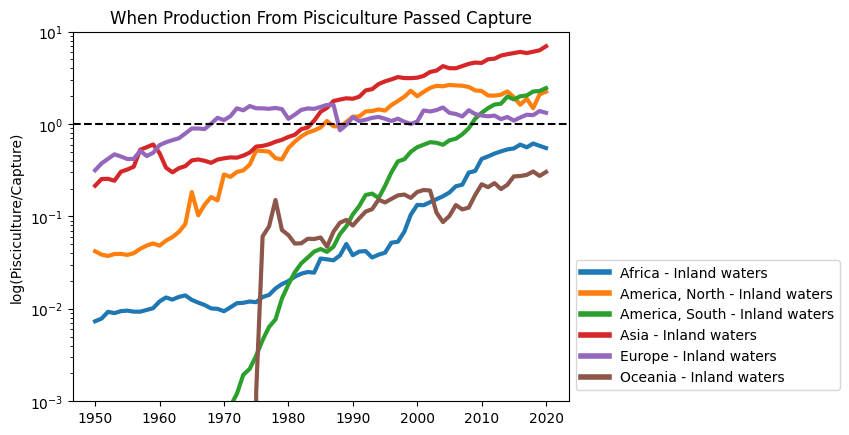

In [19]:
snsplot = sns.lineplot(data = period_waterArea_group[period_waterArea_group['Inland_Oceanic'] == 'Inland'], 
                       x = 'PERIOD', y = 'Aquaculture_Capture_Ratio', hue = 'WaterArea', linewidth = 3)

snsplot.set(yscale='log', 
            xlabel = "", 
            ylabel = "log(Pisciculture/Capture)", 
            ylim = (0.001, 10),
            title = "When Production From Pisciculture Passed Capture")

snsplot.axhline(1, linestyle = "--", color = 'black')
leg = plt.legend(bbox_to_anchor=(1, 0.4))
for line in leg.get_lines():
    line.set_linewidth(4)

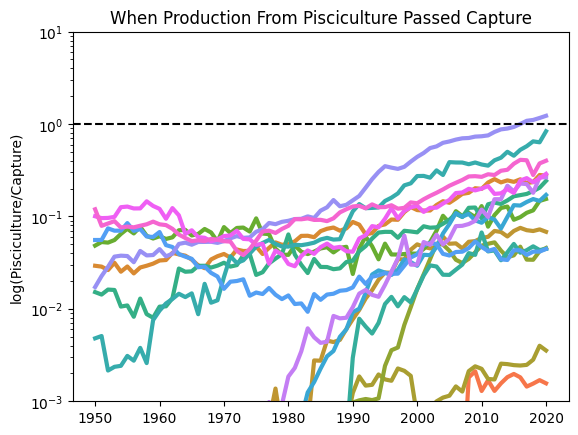

In [23]:
# not used, table above summerises this
snsplot = sns.lineplot(data = period_waterArea_group[period_waterArea_group['Inland_Oceanic'] == 'Oceanic'], 
             x = 'PERIOD', y = 'Aquaculture_Capture_Ratio', hue = 'WaterArea', legend = False, linewidth = 3)

snsplot.set(yscale='log', 
            xlabel = "", 
            ylabel = "log(Pisciculture/Capture)", 
            ylim = (0.001, 10),
            title = "When Production From Pisciculture Passed Capture")

snsplot.axhline(1, linestyle = "--", color = 'black');

So from the ratio data, we can see that oceanic waters still produce far more fish through capture than pisciculture. While inland waters have become dominated by pisciculture in 4/6 continents, although Europe shows a ratio of only just over 1. Exceptions are Africa and Oceania. Asia shows 7x fish produced by pisciculture from inland waters than natural capture.

# Global proportions from capture and pisciculture

Show total world captured vs farmed fish production since 1950

In [24]:
total_capture_aquaculture = (capture_aquaculture_merged
                             .groupby(['PERIOD'], as_index=False)
                             [['Quantity_Aquaculture', 'Quantity_Capture']]
                             .sum())

In [25]:
total_capture_aquaculture_melt = pd.melt(total_capture_aquaculture, 
                                         id_vars = 'PERIOD', 
                                         value_vars = ['Quantity_Aquaculture', 'Quantity_Capture'],
                                         value_name = "Tonnes")

In [26]:
total_capture_aquaculture_melt.head()

,PERIOD,variable,Tonnes
0,1950,Quantity_Aquaculture,550246.0
1,1951,Quantity_Aquaculture,682382.0
2,1952,Quantity_Aquaculture,784426.0
3,1953,Quantity_Aquaculture,923901.0
4,1954,Quantity_Aquaculture,1036474.0


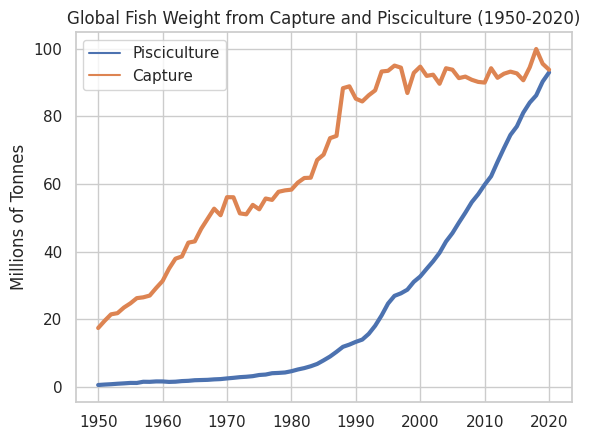

In [29]:
sns.set_theme(style = "whitegrid")

g = sns.lineplot(total_capture_aquaculture_melt, 
                 x = 'PERIOD', 
                 y = total_capture_aquaculture_melt['Tonnes'] / 1000000, 
                 hue = 'variable',
                 linewidth = 3)

g.legend_.set_title("")
# set new legend labels
new_labels = ['Pisciculture', 'Capture']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

g.set(xlabel = None,
      ylabel = "Millions of Tonnes",
      title = "Global Fish Weight from Capture and Pisciculture (1950-2020)")

plt.ticklabel_format(style='plain', axis='y')

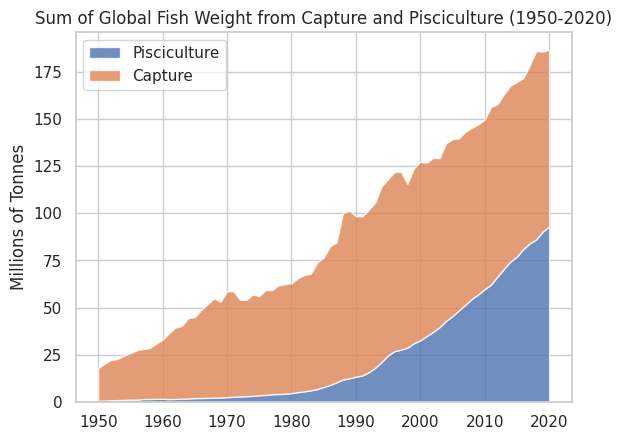

In [31]:
sns.set_theme(style = "whitegrid")
plt.stackplot(total_capture_aquaculture.PERIOD, total_capture_aquaculture.Quantity_Aquaculture / 1000000, 
              total_capture_aquaculture.Quantity_Capture / 1000000, labels=['Pisciculture', 'Capture'], alpha = 0.8)
plt.legend(loc='upper left')
plt.xlabel(None)
plt.ylabel("Millions of Tonnes")
plt.title("Sum of Global Fish Weight from Capture and Pisciculture (1950-2020)");

So, in the past two years, pisciculture has just caught up with capture in terms of weight. Total fish caught from oceans reached peak over 30 years ago. This period was also the start of the boom in terms of pisciculture which now had a market to supply as fish demand outstripped what the oceans could provide. This pattern is only going to continue as our population grows and the average person eats more and more animal protein. 

In [32]:
total_capture_aquaculture_inland = capture_aquaculture_merged.groupby(['PERIOD', 'WaterArea'], as_index=False)['Quantity_Aquaculture', 'Quantity_Capture'].sum()

/home/sean/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [33]:
africa_asia_inland = ['Africa - Inland', 'Asia - Inland']
total_capture_aquaculture_inland = total_capture_aquaculture_inland[total_capture_aquaculture_inland['WaterArea'].str.contains('|'.join(africa_asia_inland))]
total_capture_aquaculture_inland = pd.melt(total_capture_aquaculture_inland, id_vars = ['PERIOD', 'WaterArea'], 
                                           value_vars = ['Quantity_Aquaculture', 'Quantity_Capture'],
                                           value_name = "Tonnes")

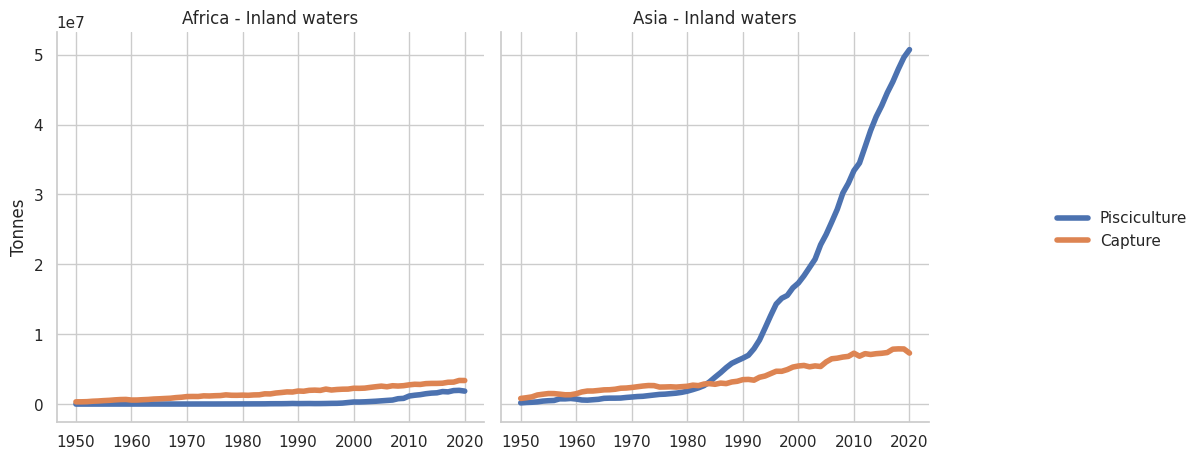

In [35]:
sns.set_theme(style = "whitegrid")
g = sns.FacetGrid(total_capture_aquaculture_inland, col = "WaterArea", 
                  hue = 'variable', sharey = True, height = 5, margin_titles=True)
g.set_titles(col_template = '{col_name}')
g.map(sns.lineplot, 'PERIOD', 'Tonnes', linewidth = 4)
g.add_legend()
g._legend.set_title("")
new_labels = ['Pisciculture', 'Capture']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
g.set(xlabel=None);

push Africa data back 15 years, how do the trends line up?

In [36]:
total_capture_aquaculture_inland['Adj Year'] = np.where(total_capture_aquaculture_inland['WaterArea'] == 'Africa - Inland waters', 
                                                        total_capture_aquaculture_inland['PERIOD'] - 40, total_capture_aquaculture_inland['PERIOD'])
total_capture_aquaculture_inland.head()

,PERIOD,WaterArea,variable,Tonnes,Adj Year
0,1950,Africa - Inland waters,Quantity_Aquaculture,2393.0,1910
1,1950,Asia - Inland waters,Quantity_Aquaculture,173932.0,1950
2,1951,Africa - Inland waters,Quantity_Aquaculture,2574.0,1911
3,1951,Asia - Inland waters,Quantity_Aquaculture,231090.0,1951
4,1952,Africa - Inland waters,Quantity_Aquaculture,3242.0,1912


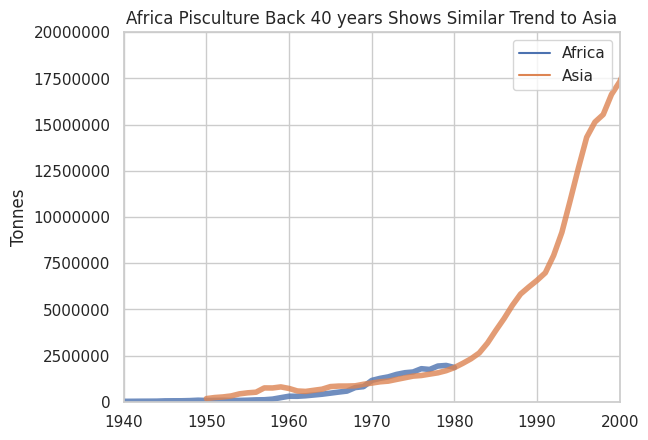

In [37]:
sns.set_theme(style = "whitegrid")

g = sns.lineplot(total_capture_aquaculture_inland[total_capture_aquaculture_inland['variable'] == 'Quantity_Aquaculture'], 
                 x = 'Adj Year', 
                 y = 'Tonnes', 
                 hue = 'WaterArea',
                 linewidth = 4,
                 alpha = 0.8)

g.legend_.set_title("")
new_labels = ['Africa', 'Asia']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)
    
g.set(xlabel = None,
      ylabel = "Tonnes",
      title = "Africa Pisculture Back 40 years Shows Similar Trend to Asia",
      xlim = (1940, 2000),
      ylim = (0,20000000))

plt.ticklabel_format(style='plain', axis='y')

To finish off, I will plot the relationship between capture and pisciculture for each country. I will normalise for population to see real differences in the relationships between the two across time.

In [39]:
population_by_country = pd.read_csv("../data/Population_by_Country.csv")
print(population_by_country.shape)

(235, 2)


In [41]:
capture_aquaculture_merged = pd.merge(capture_aquaculture_merged, population_by_country)

In [44]:
compare_1990_2020 = capture_aquaculture_merged[capture_aquaculture_merged['PERIOD'].isin([1990, 2020])]
compare_1990_2020.head()

,PERIOD,Quantity_Aquaculture,Country,WaterArea,Species,Scientific_Name,Quantity_Capture,Population
0,2020,8000.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae,0.0,38928346
30,1990,300.0,Afghanistan,Asia - Inland waters,Cyprinids nei,Cyprinidae,0.0,38928346
52,2020,50.0,Afghanistan,Asia - Inland waters,Rainbow trout,Oncorhynchus mykiss,0.0,38928346
93,2020,0.0,Afghanistan,Asia - Inland waters,Freshwater fishes nei,Actinopterygii,2000.0,38928346
123,1990,0.0,Afghanistan,Asia - Inland waters,Freshwater fishes nei,Actinopterygii,1100.0,38928346


In [52]:
compare_1990_2020 = (compare_1990_2020
                     .groupby(['PERIOD', 'Country'], as_index = False)
                     .agg({'Quantity_Aquaculture': 'sum',
                           'Quantity_Capture': 'sum',
                           'Population': 'mean'}))

,PERIOD,Country,Quantity_Aquaculture,Quantity_Capture,Population
0,1990,Afghanistan,0.051127,0.082348,38928346.0
1,1990,Albania,1.278040,1.344188,2877797.0
2,1990,Algeria,0.049560,0.160395,43851044.0
3,1990,American Samoa,0.000000,4.797542,55191.0
4,1990,Andorra,0.000000,0.000000,77265.0


In [72]:
compare_1990_2020['Quantity_Aquaculture'] = np.log((compare_1990_2020['Quantity_Aquaculture'] / 
                                             (compare_1990_2020['Population'] / 1000000)) + 1)

compare_1990_2020['Quantity_Capture'] = np.log((compare_1990_2020['Quantity_Capture'] / 
                                         (compare_1990_2020['Population'] / 1000000)) + 1)

In [73]:
compare_1990_2020.head()

,PERIOD,Country,Quantity_Aquaculture,Quantity_Capture,Population
0,1990,Afghanistan,8.661038e-07,0.000001,38928346.0
1,1990,Albania,4.341720e-02,0.045241,2877797.0
2,1990,Algeria,5.874171e-07,0.000002,43851044.0
3,1990,American Samoa,0.000000e+00,7.293432,55191.0
4,1990,Andorra,0.000000e+00,0.000000,77265.0


(204, 5)


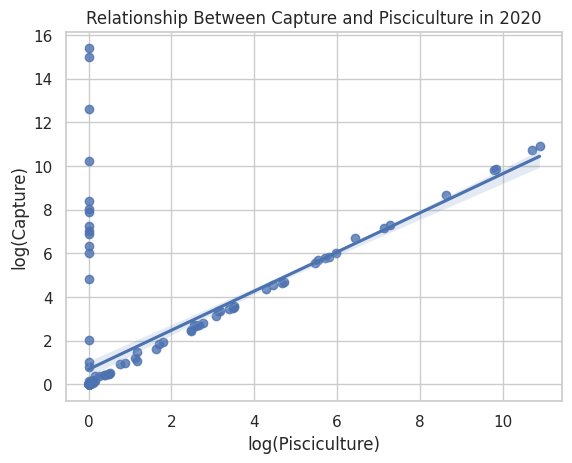

In [74]:
data = compare_1990_2020[compare_1990_2020['PERIOD'] == 2020].replace([np.inf, -np.inf], np.nan).dropna()
print(data.shape)
sns.regplot(data = data, x = 'Quantity_Aquaculture', y = 'Quantity_Capture', fit_reg=True)
#plt.xlim(-3, 13)
#plt.ylim(0, 17)
plt.title("Relationship Between Capture and Pisciculture in 2020")
plt.xlabel("log(Pisciculture)")
plt.ylabel("log(Capture)");

So there are countries that have no official record of pisciculture but have including high levels of capture, but no countries with the opposite.

(192, 5)


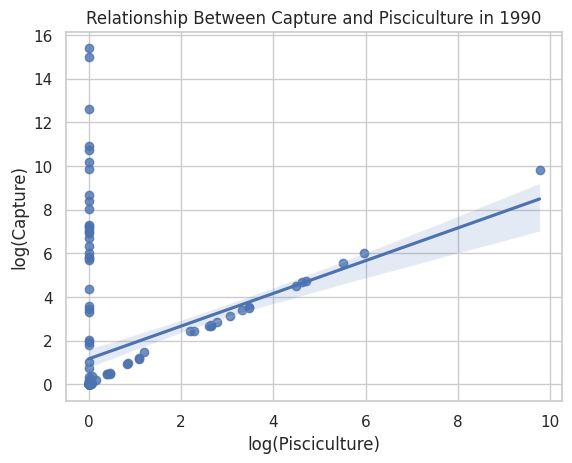

In [76]:
data = compare_1990_2020[compare_1990_2020['PERIOD'] == 1990].replace([np.inf, -np.inf], np.nan).dropna()
print(data.shape)
g = sns.regplot(data = data, x = 'Quantity_Aquaculture', y = 'Quantity_Capture')
# plt.xlim(0, 2)
# plt.ylim(0, 2)
plt.title("Relationship Between Capture and Pisciculture in 1990")
plt.xlabel("log(Pisciculture)")
plt.ylabel("log(Capture)");

In both years, the relationship is very tight and almost at 1:1. There are however countries that have no pisciculture data but do still have capture..... how does this square with the global empate between the two sources.